# Diamond Prices - Regression

The following dataset represents diamonds of every sort with multiple features describing each one. There are close to 54000 entries in this dataset. The diamonds are identified by:<br>
- Carat: weight (measured in carat, which is 0.2g)
- Cut: cut quality (in increasing order Fair, Good, Very Good, Premium, Ideal)
- Color: color of the diamond (in increasing quality J, I, H, G, F, E, D), with D being the best and J the worst
- Clarity: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
- Depth: calculated by the height of a diamond, measured from the culet to the table, divided by its average girdle diameter (the image below gives interpretations to all the "diamond-wise" vocabulary).
- Table: The diamond's table size, expressed as a percentage of its diameter.
- Price: the diamond's price. This is the value we wish to predict using a model later on in the notebook
- X: the length of the diamond in mm.
- Y: the width of the diamond in mm.
- Z: the depth of the diamond in mm.
<br><br>
As Mentioned before, our purpose in this notebook is to determine the price of a diamond (not necessarily from this dataset), given every other feature of a diamond except its price.<br>
Link to the dataset on kaggle: https://www.kaggle.com/shivam2503/diamonds

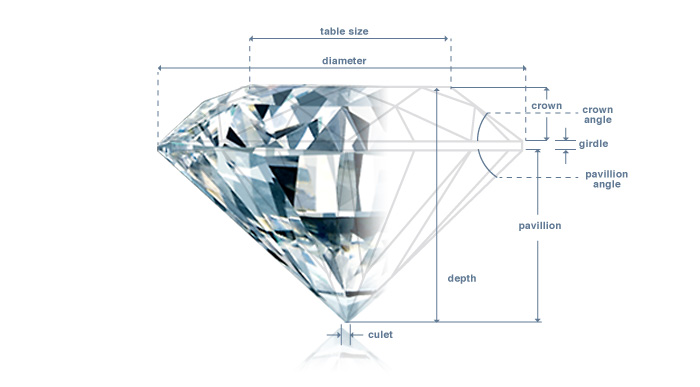

In [ ]:
#Importing the libraries used
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score

First, we have to import the dataset .csv file into the notebook. Kaggle adds an index to the data, but upon import, the notebook also gives an index to the data, rendering Kaggle's index (named "Unnamed: 0") useless, so we drop it.

In [ ]:
df = pd.read_csv('../input/diamonds/diamonds.csv') #importing the dataframe from the appropriate folder
df = df.drop(['Unnamed: 0'], axis = 1) #removing the column of default indexes: the change was not necessary, only
#for the sake of appearance

## Data Cleaning
Presenting the recieved dataset at the end for review.

In [ ]:
df

Below, the info() function is run, showing the attributes of the dataset, as well as the number of values each attribute has (telling us in a roundabout way that there are no NaN values, although we will see this explicitly later in just a second), and the data type of each attribute. As we can see that several of the attributes are of the type "object" and from a quick review we can see that they are of type "string", which we will have to encode to numerical values before applying any machine learning models.

In [ ]:
df.info()

As promised, here we can see explicitly that there are no NaN values to deal with in this dataset.

In [ ]:
df.isna().sum()

In order to encode the strings from the dataset as numerical values, we first have to understand the values they consist of. Although we were told at the beginning of the notebook the values, it is always good practice to double check, to avoid all kinds of bugs and inconvieniences. This is done below.

In [ ]:
print('Cut:\n', df['cut'].value_counts(), '\n')
print('Color:\n', df['color'].value_counts(), '\n')
print('Clarity:\n', df['clarity'].value_counts(), '\n')

Now that we know what each string attribute consists of, we can encode the values appropriately. This is done using the replace() function, which replaces the listed values by others which we specify. For example, wherever the word "Ideal" in the "cut" attribute appears, it is changed to the number "4". In a similar way, all other values are treated. The values are chosen to be 0 for the worst of the list and going upwards through the integers from it.

In [ ]:
df['cut'] = df['cut'].replace({'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4})
df['color'] = df['color'].replace({'J': 0, 'I': 1, 'H': 2, 'G': 3, 'F': 4, 'E': 5, 'D': 6})
df['clarity'] = df['clarity'].replace({'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7})

We can notice that some of the values are not as they should be. We can see that some of the widths ("y"), lengths ("x") and depths ("z") of the records (diamonds) are zeroes. This is, of course, impossible. We can also notice, that wherever the "x" or "y" value is 0, the "z" value is also 0. Because there are only 20 such records with zeroes in the "z" attribute, it seems more appropriate to drop these records, as it seems wrong to put some value instead (mean or median).<br>
The following two cells of code displays these values, where the first cell presents the "x" and "y" records with zeroes, whereas the second cell shows the "z" counterpart as well as the total number of records to be dropped.

In [ ]:
print(df.groupby('x').get_group(0), '\n')
print(df.groupby('y').get_group(0), '\n')

In [ ]:
print('Total number of records to be dropped:', len(df.groupby('z').get_group(0)))
df.groupby('z').get_group(0)

The following code cell drops said values, by first selecting them and putting the indexes of those records (as a series) into a variable. Then, dropping the indexes from the original dataset. 

In [ ]:
zeroes = df.groupby('z').get_group(0).index
df = df.drop(zeroes)

Below we create a dataframe of correlations between every attribute with one another. The dataframe represents the linear correlation between the attributes (non linear relations have very low values as the functions considers only linear relations). The values range between -1 and 1, where positive values represent positive relations ("as X increases, Y increases"), while negative value represent negative relations ("as X increases, Y decreases"). All attribute has an exact linear relation with itself (1.0000). A final thing to not is that the table presented has many duplicates (we could remove the upper right triangle (if the table was cut diagonally from the upper-left corner to the lower-right corner), and not lose any data).<br>
Using this data, we plot a heatmap using seaborn, to better and easier see the higher values.

In [ ]:
plt.figure(figsize=(7,5))
sns.heatmap(df.corr(), cmap = 'Blues', annot=True, fmt=".2f")

We can see from the correlations dataframe that the x, y and z attributes have an extremely high linear correlation with one another, and from a logical point of view we can understand that as the length grows (for example), so do the width and the depth. As the 3 attributes are closely related to one another, we can try to think of a way to combine the 3, in order to maximize the future model's effectiveness. The best solution in my point of view is to multiply the 3 columns by one another, and putting the returned values into a new column, thus creating the column "volume". It has to be noted, that that the volume calculated is not of the diamond itself, but the "box" enclosing it on all size. The value, of course, is greater than the true volume of the diamond, but hte true volume of the diamond is not the purpose of this notebook. The proportions remain true, and that is what is needed for the models ahead.<br>
So we create a new column as was described, and drop the used values of x, y and z.

In [ ]:
df['boxVolume'] = df['x'] * df['y'] * df['z']
df = df.drop(['x', 'y', 'z'], axis = 1)
df

Below are the histogams of every attribute and the with the attribute values as the x axis and the amount of records with said value in said attribute as the y axis. For our purposes, it is of almost no significance, except to visually understand the approximate distributions of values over the dataframe. This is needed in turn to understand that the data is not "capped" on either end (for example), meaning that the actual values were not rounded to a certain value if they were above that value, and likewise below. Another use for the histograms is seing that there are suffficient records for most if not all values of every attribute, for example if all reviewers were men, there will be no point of that attribute for the model's purposes.

In [ ]:
df.hist(bins=50, figsize=(20,15))

# to see again
Again, We present a correclations dataframe of the diamonds after the changes we have done.

In [ ]:
plt.figure(figsize=(7,5))
sns.heatmap(df.corr(), cmap = 'Blues', annot=True, fmt=".2f")

In [ ]:
plt.scatter(df['carat'], df['boxVolume'], alpha = 0.1)

Again, we can see an extremely high linear correlation between the "boxVolume" and the "carat" weight of the diamond. Following a similar logic as before, we are going to drop the created "boxVolume" attribute.

In [ ]:
df = df.drop(['boxVolume'], axis = 1)

Due to there being a high correlation between the diamond weight ("carat") and the diamond price, we shall plot a scatter graph of diamond weight vs price. We can see that much of the data is in roughly a parabolic (exponential) to linear shape, which suggests that the model of linear regression might be of use in this dataframe.<br>
furthermore, there are multiple outliers to the data. If their number was small (int the units), it might have been a good idea to remove them from consideration as they could be "anomalies", or the data was input wrong, to name but 2 options. Since it is not the case with our data, I choose not to ignore the outliers, but rather include them with all the rest for consideration of the model.

In [ ]:
plt.scatter(df['carat'], df['price'], alpha = 0.1)
plt.xlabel('Weight (carat)')
plt.ylabel('Price')
plt.title('Weight vs price correlation')

One last thing we have to do before we split the data into train and test sets, we have to normalize the values. As all are values are now numerical, and there are no NaN values, we can do that without too much trouble. The normalization will only be done on the values which will be given to us in the future for prediction (all data except the attribute which we have decided to predict: the overall satisfaction of the reviewer). In this case, the overall satisfaction is already normalized as it comprises of values 0 and 1 only, but in general it is not necessary to normalize the attribute for prediction.<br>
We choose normalizaiton and not standartization due to standartization giving less weight to the outliers of the dataframe.<br><br>
To normalize the data, we first split it to x and y, and mentioned above.

In [ ]:
x = df.drop(['price'], axis = 1)
y = df['price']

Next, we use the fuction min_max_scaler.fit_transform() method to achive normalization of the data.

In [ ]:
z = x.values #returns a numpy array
min_max_scaler = MinMaxScaler()
z_scaled = min_max_scaler.fit_transform(z)
x = pd.DataFrame(z_scaled)
x

## Models
Now that we are finished with data cleaning, we have a dataset, where there are no NaN values, all attributes are numerical and normalized, we can split the data using the train_test_split() method. The method splits the data according to a random state (an integer), so that over multiple reruns, the resulting dataframes from the method remain the same. The test size is set to the standard 0.2 (20%), which results in close to 11000 records (which is enough in my opinion).

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

Now that we have split our data, we can get down to the models. Before choosing and applying the model to the data, we need a baseline model, to compare all others to it: if the models thereafter are worse than the base model, then the model we are evaluating is not good, to say the least. If the model is better than the base model, on the other hand, it means that the model works, and is able to be better at predicting than a "dummy" model. The base model we will use is "Dummy Regressor", which will, regardless of the input, put in the the median of all values in y_train. It puts in the most median value due to the strategy we have put into the model, although we could choose differently, but this strategy seems to return the best results.

after using the model.fit() and model.predict() methods and saving the predictions for later use if needed, we can use the model.score() method to test a see the r2 value of the results. in our case, the r2 turns out ot be negative, which is not very good at all as we strive for the r2 to return a value as close to 1 as possible. From the r2 score we can understand that the model does not represent the data in any way.<br>
The r2 equation is as follows:
$$ R^{2} = \frac{variance_{mean} - variance_{model}}{variance_{mean}} $$

### Dummy Classifier

In [ ]:
dummyModel = DummyRegressor(strategy = "median")
dummyModel.fit(X_train, y_train)
predictionsDummy = dummyModel.predict(X_test)
r2ScoreDummy = dummyModel.score(X_test, y_test)

Now that we know what a bad model looks like, lets try to find a better one. We will use Linear Regression. We define the model, run the fit() method to fit the training data, and the predict() method to use the model to predict values and save them to a new variable.

In [ ]:
modelLinReg = LinearRegression()
modelLinReg.fit(X_train, y_train)
predictionsLinReg = modelLinReg.predict(X_test)
predictionsLinReg

Now we can calculate the RMSE (Root Mean Square Error - The standard deviation of residuals) and the r2 score (described above).<br>
The RMSE is calculated by:
$$ RMSE = \sqrt{\frac{\sum_{i=1}^{N} (x_{i} - \hat{x}_{i})^{2}}{N}} $$
From the values recieved we can understand:
- The model is quite good - the R2 value is 0.9, which is close to 1, thus meaning that the variance of the model is quite low.
- The RMSE isrelatively low, considering that the prices range from almost 0 to 18000 (approximately)

In [ ]:
final_mse = mean_squared_error(y_test, predictionsLinReg)
final_rmse = np.sqrt(final_mse)

r2ScoreLinReg = r2_score(y_test, predictionsLinReg)
print('RMSE =', final_rmse, '\nR2 =', r2ScoreLinReg)

Below we calculate the best cv parameter (K-folds) value for the cross validation score. We run from 2 to 20. The cv value in cross validation score means the number of "folds" the training set is divided into.<br>
Cross validation is when we divide the training set into a certain number of parts of identical length. There are made this certain anount of runs, when for each run, a different one of the divided sets is set aside. The model runs as in the usual trainig set, then another "piece" of the training set is used. Their performances are recorded, and the mean value is displayed.<br><br>
We have identified after these runs that 5 is the best number of k-folds for this data (out of the given range at least). As we were hoping, the r2 score matches (almost) the r2 score of the original model, meaning the model works as expected and most probably the model is neither underfitted or overfitted.

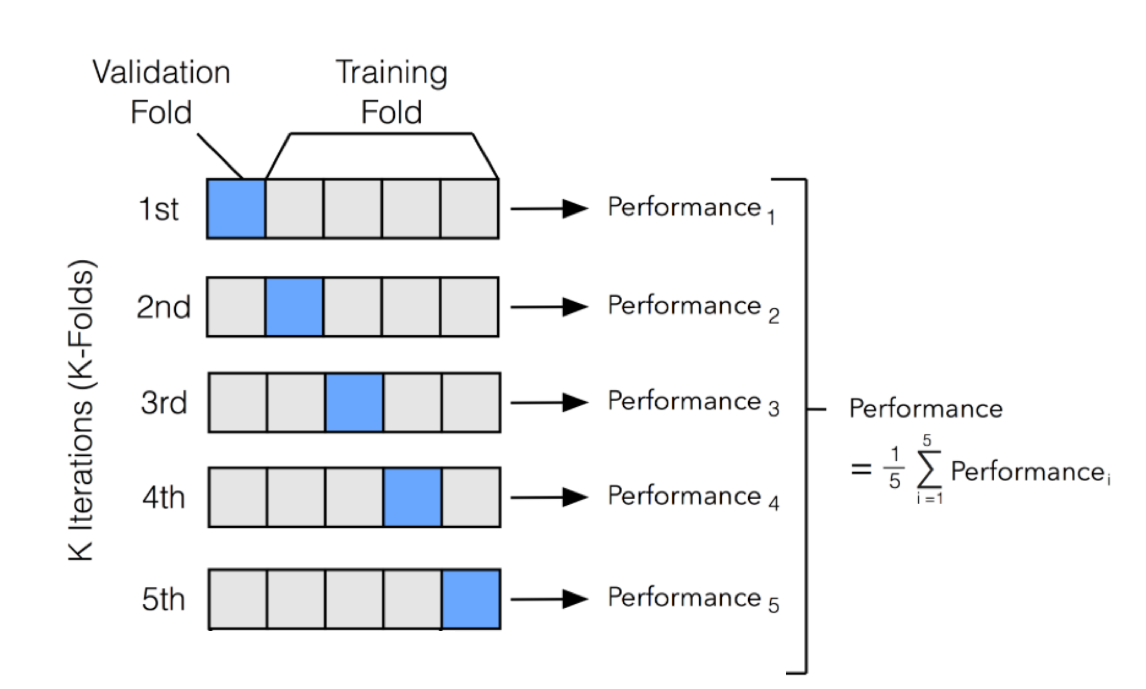

In [ ]:
def chooseKFold():
    maxi = 1 #saving the index of the highest score
    max = 0 #saving the value of the highest score
    for i in range(2,20):
        accuracy = cross_val_score(modelLinReg, X_train, y_train, cv = i).mean()
        if (accuracy > max):
            maxi = i
            max = accuracy
    print('Best index:', maxi, "\ncross_val_score of index", maxi, ':', max)
chooseKFold()

In [ ]:
fig = plt.figure()
r2Scores = [r2ScoreDummy, r2ScoreLinReg]
r2ScoresSize = np.arange(len(r2Scores))
axes = fig.add_axes([0,0,1,1])
axes.bar(['Dummy', 'Linear Regression'], r2Scores)
axes.set_ylabel("Accuracy Score")
axes.set_title("Accuracy Scores of the different models")

In [ ]:
modelLinReg.coef_ 

Co cocnlude, we have found a models that works very well with our dataset. It is able to predict the diamond's price based on the features of the diamond with an r2 score of 0.903. We checked and can say with some certainty that the model is not overfitted and not underfitted.